In [217]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [218]:
dx = 1
dy = 1
nx = 3
ny = 3

source = np.array([[0, 0.25], [0, 1.5], [0, 2.75]])
receiver = np.array([[3, 0.25], [3, 1.5], [3, 2.75]])

In [219]:
N = 1001
ns = source.shape[0]
nr = receiver.shape[0]

In [220]:
G = np.zeros((ns * nr, nx * ny))
rays = []

In [221]:
# Iteration to fill the Kernel matrix G
for i in range(ns):
    for j in range(nr):
        ij = i * nr + j
        dist = np.linalg.norm(receiver[j] - source[i])
        dd = dist / N

        cosx = (receiver[j, 0] - source[i, 0]) / dist * dd
        cosy = (receiver[j, 1] - source[i, 1]) / dist * dd

        x0 = source[i, 0]
        y0 = source[i, 1]

        idx = int(np.ceil(x0 / dx))
        if np.isclose(x0 % dx, 0.0):
            idx += 1
        idy = int(np.ceil(y0 / dy))
        if np.isclose(y0 % dy, 0.0):
            idy += 1
        indx0 = (idy - 1) * ny + idx

        d1 = 0.0
        xs, ys = [x0], [y0]   # simpan koordinat ray

        for k in range(1, N + 2):
            xi = cosx * k + x0
            yi = cosy * k + y0
            xs.append(xi)
            ys.append(yi)

            idx = int(np.ceil(xi / dx))
            idy = int(np.ceil(yi / dy))
            indx = (idy - 1) * ny + idx

            if indx == indx0:
                d1 += dd
            else:
                G[ij, indx0 - 1] = d1
                d1 = dd
                indx0 = indx

        # simpan jalur ray
        rays.append((source[i], receiver[j], xs, ys))

# The resulting matrix G (printed with 4 decimal places to match the example)
print(np.round(G, 4))

[[0.998  1.001  1.001  0.     0.     0.     0.     0.     0.    ]
 [1.0812 0.8669 0.     0.     0.2175 1.0812 0.     0.     0.    ]
 [1.1704 0.     0.     0.1287 1.303  0.1287 0.     0.     1.1743]
 [0.     0.8669 1.0812 1.0812 0.2175 0.     0.     0.     0.    ]
 [0.     0.     0.     0.998  1.001  1.001  0.     0.     0.    ]
 [0.     0.     0.     1.0812 0.2175 0.     0.     0.8669 1.0812]
 [0.     0.     1.1743 0.1287 1.303  0.1287 1.1704 0.     0.    ]
 [0.     0.     0.     0.     0.2175 1.0812 1.0812 0.8669 0.    ]
 [0.     0.     0.     0.     0.     0.     0.998  1.001  1.001 ]]


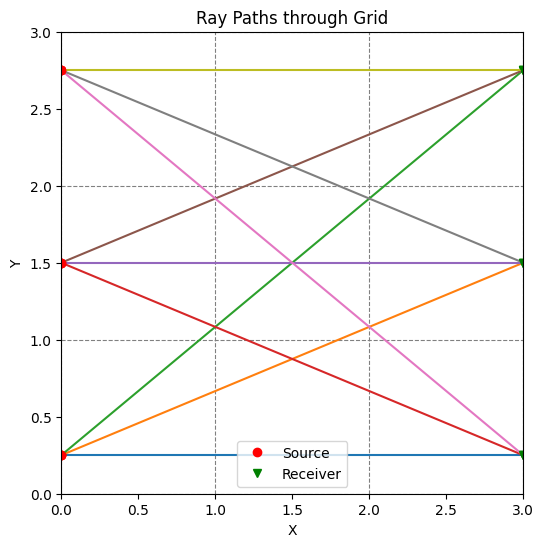

In [222]:
fig, ax = plt.subplots(figsize=(6, 6))

# gambar grid
for ix in range(nx+1):
    ax.axvline(ix*dx, color="gray", linestyle="--", linewidth=0.8)
for iy in range(ny+1):
    ax.axhline(iy*dy, color="gray", linestyle="--", linewidth=0.8)

# plot ray paths
for (s, r, xs, ys) in rays:
    ax.plot(xs, ys, '-', linewidth=1.5)
    ax.plot(s[0], s[1], 'ro', label="Source" if "Source" not in ax.get_legend_handles_labels()[1] else "")
    ax.plot(r[0], r[1], 'gv', label="Receiver" if "Receiver" not in ax.get_legend_handles_labels()[1] else "")

ax.set_xlim(0, nx*dx)
ax.set_ylim(0, ny*dy)
ax.set_aspect('equal')
ax.set_title("Ray Paths through Grid")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
plt.show()

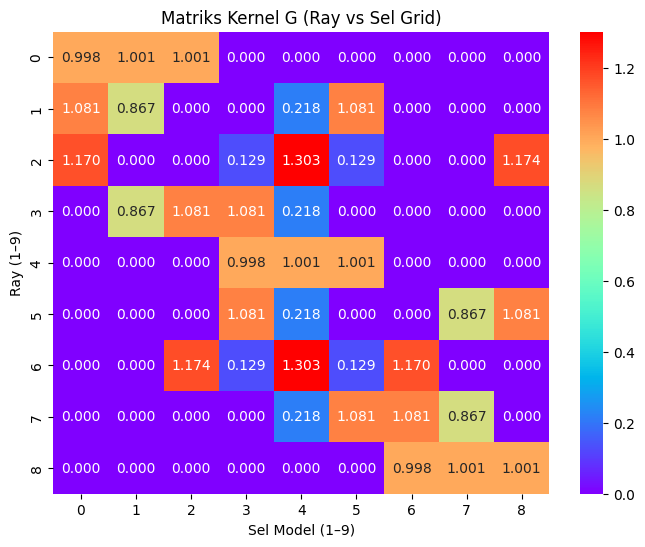

In [223]:
# Visualisasi kernel sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(G, annot=True, fmt=".3f", cmap="rainbow", cbar=True)

plt.title("Matriks Kernel G (Ray vs Sel Grid)")
plt.xlabel("Sel Model (1–9)")
plt.ylabel("Ray (1–9)")
plt.show()

In [224]:
d = np.array([3., 3.1622777, 3.6055513, 3.1622777, 3., 3.1622777, 3.6055513, 3.1622777, 3.], dtype=float).reshape(-1, 1)

In [225]:
A = G.T @ G
B = G.T @ d
A_inv = np.linalg.inv(A)

In [226]:
m = A_inv @ B
pd.DataFrame(m)

,0
0,-11.460797
1,-43.502097
2,53.453047
3,-9.859878
4,-40.653219
5,56.427773
6,-19.295328
7,-30.212108
8,52.470284


In [227]:
def equation(G, d, epsilon):
    I = G.shape[1]
    A = (G.T @ G) + (epsilon**2) * np.eye(I)
    B = G.T @ d
    m = np.linalg.solve(A, B)
    return m

In [228]:
m_true = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=float)

In [229]:
eps_values = np.arange(0.0, 10.01, 0.0001)
results = []

In [230]:
for eps in eps_values:
    m = equation(G, d, eps)
    residual_norm = np.linalg.norm((G @ m) - d)
    model_norm = np.linalg.norm(m)
    results.append([eps, residual_norm, model_norm])

In [231]:
df = pd.DataFrame(results, columns=["epsilon", "residual_norm", "model_norm"])
df

,epsilon,residual_norm,model_norm
0,0.0000,2.688246e-11,112.203635
1,0.0001,7.098902e-04,108.906508
2,0.0002,2.803946e-03,107.541536
3,0.0003,6.179696e-03,105.341143
4,0.0004,1.067997e-02,102.407816
...,...,...,...
100095,10.0095,8.661687e+00,0.291259
100096,10.0096,8.661704e+00,0.291253
100097,10.0097,8.661722e+00,0.291248
100098,10.0098,8.661740e+00,0.291243


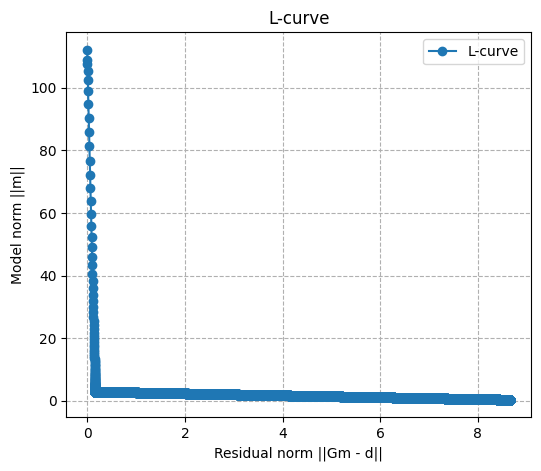

In [232]:
plt.figure(figsize=(6, 5))
plt.plot(df["residual_norm"], df["model_norm"], 'o-', label="L-curve")

plt.xlabel("Residual norm ||Gm - d||")
plt.ylabel("Model norm ||m||")
plt.title("L-curve")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [233]:
m_true = np.ones(G.shape[1]) 

errors = []
for eps in eps_values:
    m = equation(G, d, eps)
    residual_norm = np.linalg.norm(G @ m - d)
    model_norm = np.linalg.norm(m)
    model_error = np.linalg.norm(m - m_true)
    results.append([eps, residual_norm, model_norm, model_error])
    errors.append(model_error)

df = pd.DataFrame(results, columns=["epsilon", "residual_norm", "model_norm", "model_error"])

best_idx = np.argmin(df["model_error"])
best_epsilon = df.loc[best_idx, "epsilon"]
residual_best = df.loc[best_idx, "residual_norm"]
model_best = df.loc[best_idx, "model_norm"]
print("Best epsilon (berdasarkan model error) =", best_epsilon)

Best epsilon (berdasarkan model error) = 0.19740000000000002


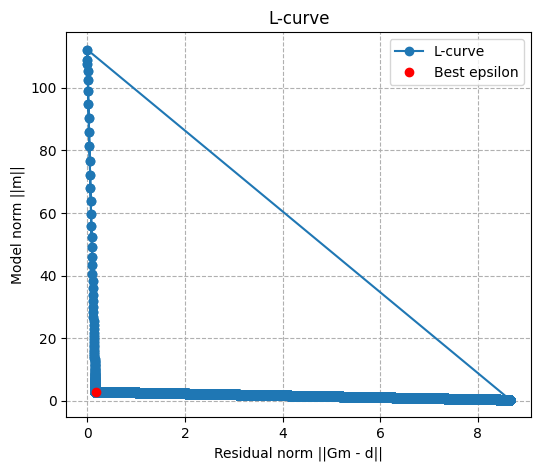

In [234]:
plt.figure(figsize=(6, 5))
plt.plot(df["residual_norm"], df["model_norm"], 'o-', label="L-curve")
plt.plot(residual_best, model_best, 'ro', label="Best epsilon")

plt.xlabel("Residual norm ||Gm - d||")
plt.ylabel("Model norm ||m||")
plt.title("L-curve")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [235]:
A = (G.T @ G) + (best_epsilon**2) * np.eye(9)
B = G.T @ d
A_inv = np.linalg.inv(A)

In [236]:
m = A_inv @ B
pd.DataFrame(m)

,0
0,0.945220
1,1.016417
2,0.951161
3,1.008175
4,0.874487
5,1.014149
6,0.945220
7,1.016417
8,0.951161
